Applying topic modelling and sentiment analysis techniques in order to extract text aspects and the sentiment expressed towards such aspects.

In [ ]:
### Medium Article - https://towardsdatascience.com/%EF%B8%8F-sentiment-analysis-aspect-based-opinion-mining-72a75e8c8a6d
### Github repo -    https://github.com/LowriWilliams/Aspect_Sentiment_Analysis
### Mobile reviews dataset - http://jmcauley.ucsd.edu/data/amazon/links.html

In [ ]:
### ! pip install aspect-based-sentiment-analysis

In [1]:
! pip install vaderSentiment

     |████████████████████████████████| 133kB 5.2MB/s 


In [2]:
! gdown --id 1qj87tve3snu_dUeSpcSpP1uIWzE0zqAg
! gdown --id 1XWupY8IyOHKLvb6Qyd5Pn63_tlnzUYSB

Downloading...
From: https://drive.google.com/uc?id=1qj87tve3snu_dUeSpcSpP1uIWzE0zqAg
To: /content/wn_affect.py
100% 21.0k/21.0k [00:00<00:00, 35.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XWupY8IyOHKLvb6Qyd5Pn63_tlnzUYSB
To: /content/stop_words_list.py
100% 6.84k/6.84k [00:00<00:00, 9.73MB/s]


In [3]:
import json
import pandas as pd
import numpy as np
import re
import sys
import nltk
from nltk.corpus import stopwords, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import collections
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from stop_words_list import stop_words_list
from wn_affect import wn_affect 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Data Preprocessing

We’ll follow the standard set of pre-processing techniques used in several natural language processing tasks. Such techniques include:

    Converting the text to lowercase.
    Removing punctuation and additional white spaces.
    Tokenisation.
    Removing stop words.
    Lemmatisation.

Before we look into applying topic modelling techniques, the last pre-processing step is to vectorise the reviews, i.e. we need to represent the data into a numerical form so that the model can handle them. There are several representations you can use, with the popular methods being the word’s TF-IDF score or their frequency counts (bag-of-words approach). Here, we’ll stick to a bag-of-words representation. We’ll use the CounterVectorizer function from Sklearn’s feature extraction module. This function converts a collection of text to a matrix of word counts.

In [ ]:
### ! wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz

--2021-02-08 14:21:12--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45409631 (43M) [application/x-gzip]
Saving to: ‘reviews_Cell_Phones_and_Accessories_5.json.gz’

reviews_Cell_Phones 100%[===================>]  43.31M  6.04MB/s    in 8.4s    

2021-02-08 14:21:21 (5.15 MB/s) - ‘reviews_Cell_Phones_and_Accessories_5.json.gz’ saved [45409631/45409631]



In [4]:
! gdown --id 1u5lrzkLqhH5e9F_3fBdLd066z4h51j3z

Downloading...
From: https://drive.google.com/uc?id=1u5lrzkLqhH5e9F_3fBdLd066z4h51j3z
To: /content/combined_book_reviews.csv
59.7MB [00:00, 128MB/s] 


In [ ]:
"""
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/content/reviews_Cell_Phones_and_Accessories_5.json.gz')
"""

In [5]:
df = pd.read_csv('/content/combined_book_reviews.csv')
df.rename(columns={'reviewText': 'reviews'}, inplace=True)
df =df [['reviews']]
df= df[df['reviews'].apply(lambda x: isinstance(x, str))]
df.reset_index(drop=True, inplace=True)

In [6]:
# case text as lowercase, remove punctuation, remove extra whitespace in string and on both sides of string

df['remove_lower_punct'] = df['reviews'].str.lower().str.replace("'", '').str.replace('[^\w\s]', ' ').str.replace(" \d+", " ").str.replace(' +', ' ').str.replace('\r','').str.replace('\n','').str.strip()


In [7]:
df.head()

,reviews,remove_lower_punct
0,This book is a revelation. I cannot stop recom...,this book is a revelation i cannot stop recomm...
1,I read this as an elderly American trying to u...,i read this as an elderly american trying to u...
2,A lot of entrepreneurship books over the last ...,a lot of entrepreneurship books over the last ...
3,"Loved FMD for years, I was excited to get this...",loved fmd for years i was excited to get this ...
4,All of these reviews on how Roth uses the F wo...,all of these reviews on how roth uses the f wo...


In [8]:
# apply sentiment analysis
analyser = SentimentIntensityAnalyzer()

sentiment_score_list = []
sentiment_label_list = []

for i in df['remove_lower_punct'].values.tolist():
    sentiment_score = analyser.polarity_scores(i)

    if sentiment_score['compound'] >= 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Positive')
    elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Neutral')
    elif sentiment_score['compound'] <= -0.05:
        sentiment_score_list.append(sentiment_score['compound'])
        sentiment_label_list.append('Negative')
    
df['sentiment'] = sentiment_label_list
df['sentiment score'] = sentiment_score_list



In [9]:
df.head()

,reviews,remove_lower_punct,sentiment,sentiment score
0,This book is a revelation. I cannot stop recom...,this book is a revelation i cannot stop recomm...,Positive,0.9915
1,I read this as an elderly American trying to u...,i read this as an elderly american trying to u...,Positive,0.8525
2,A lot of entrepreneurship books over the last ...,a lot of entrepreneurship books over the last ...,Positive,0.9467
3,"Loved FMD for years, I was excited to get this...",loved fmd for years i was excited to get this ...,Negative,-0.2500
4,All of these reviews on how Roth uses the F wo...,all of these reviews on how roth uses the f wo...,Positive,0.9876


In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
# tokenise string

df['tokenise'] = df.apply(lambda row: nltk.word_tokenize(row[1]), axis=1)

In [12]:
df.head()

,reviews,remove_lower_punct,sentiment,sentiment score,tokenise
0,This book is a revelation. I cannot stop recom...,this book is a revelation i cannot stop recomm...,Positive,0.9915,"[this, book, is, a, revelation, i, can, not, s..."
1,I read this as an elderly American trying to u...,i read this as an elderly american trying to u...,Positive,0.8525,"[i, read, this, as, an, elderly, american, try..."
2,A lot of entrepreneurship books over the last ...,a lot of entrepreneurship books over the last ...,Positive,0.9467,"[a, lot, of, entrepreneurship, books, over, th..."
3,"Loved FMD for years, I was excited to get this...",loved fmd for years i was excited to get this ...,Negative,-0.2500,"[loved, fmd, for, years, i, was, excited, to, ..."
4,All of these reviews on how Roth uses the F wo...,all of these reviews on how roth uses the f wo...,Positive,0.9876,"[all, of, these, reviews, on, how, roth, uses,..."


In [13]:

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
# initiate stopwords from nltk

stop_words = stopwords.words('english')

# add additional missing terms

stop_words.extend(stop_words_list) 

# remove stopwords

df['remove_stopwords'] = df['tokenise'].apply(lambda x: [item for item in x if item not in stop_words])

df.head()

,reviews,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords
0,This book is a revelation. I cannot stop recom...,this book is a revelation i cannot stop recomm...,Positive,0.9915,"[this, book, is, a, revelation, i, can, not, s...","[book, revelation, recommending, book, peterse..."
1,I read this as an elderly American trying to u...,i read this as an elderly american trying to u...,Positive,0.8525,"[i, read, this, as, an, elderly, american, try...","[read, elderly, american, understand, millenni..."
2,A lot of entrepreneurship books over the last ...,a lot of entrepreneurship books over the last ...,Positive,0.9467,"[a, lot, of, entrepreneurship, books, over, th...","[lot, entrepreneurship, books, decade, felt, a..."
3,"Loved FMD for years, I was excited to get this...",loved fmd for years i was excited to get this ...,Negative,-0.2500,"[loved, fmd, for, years, i, was, excited, to, ...","[loved, fmd, years, excited, book, haylie, pom..."
4,All of these reviews on how Roth uses the F wo...,all of these reviews on how roth uses the f wo...,Positive,0.9876,"[all, of, these, reviews, on, how, roth, uses,...","[reviews, roth, word, sexual, situations, slow..."


In [15]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [16]:
# initiate nltk lemmatiser

wordnet_lemmatizer = WordNetLemmatizer()

# lemmatise words

df['lemmatise'] = df['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x]) 

df.head()

,reviews,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords,lemmatise
0,This book is a revelation. I cannot stop recom...,this book is a revelation i cannot stop recomm...,Positive,0.9915,"[this, book, is, a, revelation, i, can, not, s...","[book, revelation, recommending, book, peterse...","[book, revelation, recommending, book, peterse..."
1,I read this as an elderly American trying to u...,i read this as an elderly american trying to u...,Positive,0.8525,"[i, read, this, as, an, elderly, american, try...","[read, elderly, american, understand, millenni...","[read, elderly, american, understand, millenni..."
2,A lot of entrepreneurship books over the last ...,a lot of entrepreneurship books over the last ...,Positive,0.9467,"[a, lot, of, entrepreneurship, books, over, th...","[lot, entrepreneurship, books, decade, felt, a...","[lot, entrepreneurship, book, decade, felt, ai..."
3,"Loved FMD for years, I was excited to get this...",loved fmd for years i was excited to get this ...,Negative,-0.2500,"[loved, fmd, for, years, i, was, excited, to, ...","[loved, fmd, years, excited, book, haylie, pom...","[loved, fmd, year, excited, book, haylie, pomr..."
4,All of these reviews on how Roth uses the F wo...,all of these reviews on how roth uses the f wo...,Positive,0.9876,"[all, of, these, reviews, on, how, roth, uses,...","[reviews, roth, word, sexual, situations, slow...","[review, roth, word, sexual, situation, slow, ..."


In [17]:
# initialise the count vectorizer

vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
                            
# join the processed data to be vectorised

vectors = []

for index, row in df.iterrows():
    vectors.append(", ".join(row['lemmatise']))

vectorised = vectorizer.fit_transform(vectors)

print(vectorised)

  (0, 178717)	1
  (0, 1379097)	1
  (0, 1337104)	1
  (0, 177551)	1
  (0, 1196074)	1
  (0, 514061)	1
  (0, 1766160)	1
  (0, 789131)	1
  (0, 874078)	1
  (0, 1052648)	1
  (0, 1642649)	1
  (0, 291658)	1
  (0, 1094441)	1
  (0, 776825)	1
  (0, 1052585)	1
  (0, 148354)	1
  (0, 1710073)	1
  (0, 501537)	2
  (0, 1685749)	1
  (0, 1453090)	2
  (0, 182828)	1
  (0, 1697390)	1
  (0, 182819)	1
  (0, 1164933)	1
  (0, 1052630)	1
  :	:
  (123187, 1418141)	1
  (123187, 526761)	1
  (123187, 123144)	1
  (123187, 697312)	1
  (123187, 46157)	1
  (123187, 573343)	1
  (123187, 1740)	1
  (123187, 1313885)	1
  (123188, 1379908)	1
  (123188, 1307849)	1
  (123188, 1050606)	1
  (123188, 178095)	1
  (123188, 176608)	1
  (123188, 1311762)	1
  (123188, 1284712)	1
  (123188, 724858)	1
  (123188, 178499)	1
  (123188, 45942)	1
  (123188, 1701655)	1
  (123188, 1021897)	1
  (123188, 1560108)	1
  (123188, 176434)	1
  (123188, 1105052)	1
  (123188, 1230290)	1
  (123188, 1350486)	1


In [18]:
len(vectors), vectorised.shape

(123189, (123189, 1833434))

## TOPIC MODELLING

Topic modelling is an unsupervised machine learning approach used to distribute texts into groups which best characterise such documents. This concept can also be used to extract text aspects.

Sklearn includes a version of the Latent Dirichlet Allocation (LDA) algorithm. For this concept, we want to extract five aspects. Once the parameters are set, we can fit the LDA to the vectorised version of the text.

To make the output easier to read, we can append the relevance score produced for each topic to each review as a column and calculate the dominant topic by taking the topic with the highest relevance score.





In [20]:
### df= df[['reviews', 'remove_lower_punct', 'sentiment', 'sentiment score', 'tokenise', 'remove_stopwords', 'lemmatise']]
### df.head()

In [19]:
# initisalise LDA Model

lda_model = LatentDirichletAllocation(n_components = 12, # number of topics
                                  random_state = 10,          # random state
                                  evaluate_every = -1,      # compute perplexity every n iters, default: Don't
                                  n_jobs = -1,              # Use all available CPUs
                                 )

lda_output = lda_model.fit_transform(vectorised)

# column names

topic_names = ["Topic" + str(i) for i in range(1, lda_model.n_components + 1)]

# make the pandas dataframe

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names)

# get dominant topic for each document

dominant_topic = (np.argmax(df_document_topic.values, axis=1)+1)
df_document_topic['Dominant_topic'] = dominant_topic

# join to original dataframes

df = pd.merge(df, df_document_topic, left_index = True, right_index = True, how = 'outer')
df.head()

,reviews,remove_lower_punct,sentiment,sentiment score,tokenise,remove_stopwords,lemmatise,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Dominant_topic
0,This book is a revelation. I cannot stop recom...,this book is a revelation i cannot stop recomm...,Positive,0.9915,"[this, book, is, a, revelation, i, can, not, s...","[book, revelation, recommending, book, peterse...","[book, revelation, recommending, book, peterse...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.0,0.00,0.0,8
1,I read this as an elderly American trying to u...,i read this as an elderly american trying to u...,Positive,0.8525,"[i, read, this, as, an, elderly, american, try...","[read, elderly, american, understand, millenni...","[read, elderly, american, understand, millenni...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.99,0.0,0.0,0.00,0.0,8
2,A lot of entrepreneurship books over the last ...,a lot of entrepreneurship books over the last ...,Positive,0.9467,"[a, lot, of, entrepreneurship, books, over, th...","[lot, entrepreneurship, books, decade, felt, a...","[lot, entrepreneurship, book, decade, felt, ai...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.98,0.0,11
3,"Loved FMD for years, I was excited to get this...",loved fmd for years i was excited to get this ...,Negative,-0.2500,"[loved, fmd, for, years, i, was, excited, to, ...","[loved, fmd, years, excited, book, haylie, pom...","[loved, fmd, year, excited, book, haylie, pomr...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.0,0.00,0.0,8
4,All of these reviews on how Roth uses the F wo...,all of these reviews on how roth uses the f wo...,Positive,0.9876,"[all, of, these, reviews, on, how, roth, uses,...","[reviews, roth, word, sexual, situations, slow...","[review, roth, word, sexual, situation, slow, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.98,0.0,0.0,0.00,0.0,8


In [21]:
df.to_csv('absa_df.csv', index=False)

In [22]:
lda_output.shape, vectorised.shape

((123189, 12), (123189, 1833434))

Now we can see which topic (by its number) a review belongs to. But what keywords, in this case text aspects, has the LDA extracted from such reviews? We can view them by calling the vectoriser’s get_feature_names() and see their relevance score to that aspect using the LDA’s components_functions:

We determine which aspect a keyword belongs to by taking its highest relevance score across the five aspects. Then, for each aspect, we can order our dataframe in descending order and select the keywords with the highest score.

The five aspects are:

    Battery charger
    Battery pack
    Car charger
    Cell phone
    Screen protector



In [23]:
lda_model.components_.shape, vectorised.shape

((12, 1833434), (123189, 1833434))

In [24]:
vectorizer.get_feature_names()[:5]

['006 v865', '03 nytimes', '03 real', '03 russia', '0440442508 book']

In [25]:
# index names
docnames = ['Doc' + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topic_names

df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
df_scores = pd.DataFrame(df_topic_keywords.max())

tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
tmp.columns = ['topic', 'relevance_score']

display(tmp)

,topic,relevance_score
006 v865,Topic10,1.083333
03 nytimes,Topic12,1.083333
03 real,Topic12,1.083333
03 russia,Topic11,1.083333
0440442508 book,Topic6,1.083333
...,...,...
𝗥𝗶𝘀𝗶𝗻𝗴 𝗗𝗮𝗿𝗸,Topic9,2.083333
𝗮𝗻𝗱 𝘁𝗵𝗲,Topic9,2.083333
𝗯𝗼𝗼𝗸 𝗳𝗿𝗶𝗲𝗻𝗱𝘀,Topic9,1.083333
𝗳𝗿𝗶𝗲𝗻𝗱𝘀 reading,Topic9,1.083333


In [26]:
all_topics = []

for i in tmp['topic'].unique():    
    tmp_1 = tmp.loc[tmp['topic'] == i].reset_index()
    tmp_1 = tmp_1.sort_values('relevance_score', ascending=False).head(1)

    #tmp_1['topic'] = tmp_1['topic'] + 1
    
    tmp_2 = []
    tmp_2.append(tmp_1['topic'].unique()[0])
    tmp_2.append(list(tmp_1['index'].unique()))
    all_topics.append(tmp_2)

all_topics = pd.DataFrame(all_topics, columns=['Dominant_topic', 'topic_name'])
display(all_topics)

,Dominant_topic,topic_name
0,Topic10,[book book]
1,Topic12,[book written]
2,Topic11,[read book]
3,Topic6,[excellent book]
4,Topic5,[favorite book]
5,Topic2,[polar express]
6,Topic8,[ten finger]
7,Topic7,[good book]
8,Topic4,[main character]
9,Topic3,[loved book]


In [27]:
for idx, row in all_topics.iterrows():
  m= int(row['Dominant_topic'].replace('Topic',''))
  row['Dominant_topic']=m

In [28]:
all_topics

,Dominant_topic,topic_name
0,10,[book book]
1,12,[book written]
2,11,[read book]
3,6,[excellent book]
4,5,[favorite book]
5,2,[polar express]
6,8,[ten finger]
7,7,[good book]
8,4,[main character]
9,3,[loved book]


## SENTIMENT ANALYSIS

Various techniques and methodologies have been developed to address automatically identifying the sentiment expressed in the text. In this post, I’ll use VADER, a Python sentiment analysis library, to classify whether the reviews are positive, negative, or neutral.

A very simple approach to sentiment analysis is by using a list of words which have been labelled according to their semantic orientation. For example, we can assume that the word “good” has a positive valence, whereas the word “bad” has a negative one. VADER uses this technique and provides a percentage score which represents the proportion of lyrics which fall in each sentiment category. It also provides a compound score which is computed by summing the valence scores of each word and then normalising the scores to be between -1 (most extreme negative) and +1 (most extreme positive).

What’s nice about VADER is the fact that we don’t have to pre-process the text in any way. We can feed the raw product reviews into VADER’s sentiment function and retrieve the compound scores for each.

First, we’ll import the SentimentIntensityAnalyzer function from VADER’s Python library. I’ll initialise the sentiment analyser from VADER, and then iterate over the reviews from the dataframe. I’ll then calculate whether the compound sentiment score is above or beneath the thresholds so that we can assign them with the positive, negative, or neutral label.

In [29]:
results = df.groupby(['Dominant_topic', 'sentiment']).count().reset_index()

results = results.merge(all_topics, on='Dominant_topic')
results['topic_name'] = results['topic_name'].apply(', '.join)

graph_results = results[['topic_name', 'sentiment', 'sentiment score']]
graph_results = graph_results.pivot(index='topic_name', columns='sentiment', values='sentiment score').reset_index()

graph_results.set_index('topic_name', inplace=True)

display(graph_results)

sentiment,Negative,Neutral,Positive
topic_name,,,
book book,1118,525,8441
book read,1073,565,8899
book written,1042,546,8139
excellent book,972,466,6905
favorite book,1017,605,8845
good book,1067,616,10332
good read,1406,2173,13330
loved book,953,527,6916
main character,1065,539,7414


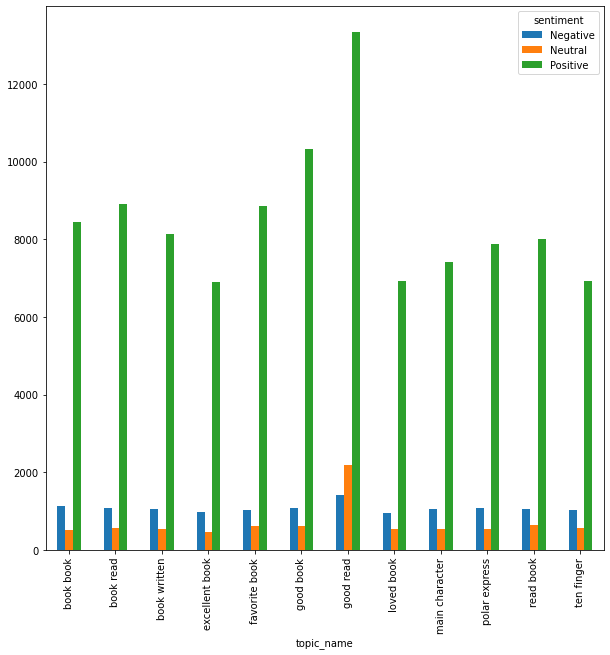

In [30]:
fig = graph_results.plot.bar(rot=90, figsize=(10,10))
fig.figure.savefig('sentiment_analysis_books_12_aspect.png', bbox_inches='tight')

## INSIGHTS FROM THE RESULTS

Once we’ve retrieved the compound scores for each review, we can plot and count the number of positive, negative, and neutral reviews for each of the five aspects.

This chart reports that the majority of the reviews for each aspect are positive. In particular, with more than 83,000 reviews, the screen protector received 49,572 positive ones. For a business, having more than 50% of your reviews expressing a positive sentiment is a good indication that your customers are satisfied with the product.

What other potential insights can we gather? Let’s dive deeper into what the customers are saying. For this concept, we’ll use the reviews for the screen protector.

One of the main features used to support Sentiment Analysis include individual sentiment words (e.g. good, bad) which explicitly convey a subjective bias. Sentiment words are available from specialised dictionaries, where they have been mapped to their sentiment.

These words are often adjectives (e.g. good, bad), adverbs (e.g. cheerfully, weirdly), nouns (e.g. blessing, rubbish), and verbs (e.g. love, hate). Sentiment may also be expressed by using comparative words (e.g. better, worse). To identify those adjectives, adverbs, nouns, and verbs in text, we can apply Part of Speech (POS) tagging. POS tagging is the process of marking up a word in a text as corresponding to a particular part of speech (noun, verb, adjective, adverb, pronoun, preposition, conjunction, interjection, numeral, article, or determiner), based on both its definition and its context.

Here, we use the NLTK POS tagger to identify the POS tags. As we’ve got quite a large dataset, we want to automatically narrow down the sentiment words as much as possible. In this case, we’re able to identify English and correctly spelt words and map them to SentiWordNet, a lexical resource for opinion mining. SentiWordNet assigns words three sentiment scores: positivity, negativity, and objectivity.

Objectivity can be defined as not being influenced by personal feelings or opinions in considering and representing facts. Subjectivity is therefore the contrast of objectivity. In terms of scoring, we want to identify words with low objectivity score. But not all subjective words are sentiment words.

To capture sentiment words from subjective ones, we use WordNet-Affect, another lexical resource which represents affective concepts correlated with affective words in a hierarchical structure. Once we’ve checked whether the subjective words are in WordNet-Affect, we can be quite confident that these are sentiment words. Based on their SentiWordNet positive and negative score, we can also split them up into separate collections and count how many times they appear across the whole dataset.

In [ ]:
### nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
"""
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        pass

positive_words = []
negative_words = []

for i in df['Dominant_topic'].unique():
    if i == 1:
        tmp_1 = df.loc[df['Dominant_topic'] == i]
                
        for j in tmp_1['tokenise'].values.tolist():
            for p in nltk.pos_tag(j):
                get_pos_tag = get_wordnet_pos(p[1])
                if type(get_pos_tag) == str:
                    try:        
                        synset = swn.senti_synset(p[0] + '.' + get_pos_tag +'.01')

                        if synset.obj_score() <= 0.49:
                            if synset.pos_score() > synset.neg_score() and p[0] in wn_affect:
                                    positive_words.append(p[0])
                            elif synset.neg_score() > synset.pos_score() and p[0] in wn_affect:
                                    negative_words.append(p[0])      
                    except:
                        pass
print(positive_words,'\n')
print(negative_words, '\n')
"""

[] 

[] 



In [ ]:
"""
unique_positive_words = list(set(positive_words))
unique_negative_words = list(set(negative_words))

count_positive_words = []
count_negative_words = []

for i in unique_positive_words:
    counter = [i, positive_words.count(i)]
    count_positive_words.append(counter)

for i in unique_negative_words:
    counter = [i, negative_words.count(i)]
    count_negative_words.append(counter)    
    
positive_words = pd.DataFrame(count_positive_words, columns = ['word', 'score'])
negative_words = pd.DataFrame(count_negative_words, columns = ['word', 'score'])

positive_words.sort_values('score', ascending=False, inplace = True)
negative_words.sort_values('score', ascending=False, inplace = True)
"""

In [31]:
"""
word_dict = {}
for k, v in positive_words.values:
    word_dict[k] = v

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('positive_words.png')
plt.show()
"""

'\nword_dict = {}\nfor k, v in positive_words.values:\n    word_dict[k] = v\n\nwordcloud = WordCloud()\nwordcloud.generate_from_frequencies(frequencies=word_dict)\nplt.figure(figsize=(20,10))\nplt.imshow(wordcloud, interpolation="bilinear")\nplt.axis("off")\nplt.savefig(\'positive_words.png\')\nplt.show()\n'

In [ ]:
"""
word_dict = {}
for k, v in negative_words.values:
    word_dict[k] = v
    
wordcloud.generate_from_frequencies(frequencies=word_dict)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('negative_words.png')
plt.show()
"""